In [6]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import binom
from math import log2
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import random

INFINITY = 9e9

class paGOMEA:
    def __init__(self, N, V, Q, d, s, e, p, u):
        self.population = []
        
        # Danh sách các ca đủ trình độ cho từng hoạt động
        self.shift_feas = [[] for i in range(N+1)]
        self.shift_feas[0].append(0)
        for i in range(N+1):
            for j in range(V+1):
                if Q[i][j] == 1:
                    self.shift_feas[i].append(j)
        
        self.N = N
        self.V = V
        self.Q = Q
        self.d = d
        self.s = s
        self.e = e
        self.p = p
        self.u = u
        
    # Tạo 1 lịch trình khả thi ngẫu nhiên
    def rand_schedule(self):
        shift = np.array([np.random.choice(i) for i in self.shift_feas])
        u = np.random.random(size=len(self.shift_feas))
        schedule = shift + u
        return schedule[1:]
    
    # Khởi tạo quần thể 
    def initialize_population(self, size = 1000):
        self.population = [self.rand_schedule() for i in range(size)]
        return
    
    # Hàm đánh giá giải pháp
    def fitness_function(self, individual):
        unsorted_individual = np.array([[0,0]] + [[individual[i], i+1] for i in range(len(individual))])
        sorted_individual = unsorted_individual[np.argsort(unsorted_individual[:, 0])]
        # Tổng thời gian di chuyển
        time_arrived = 0
        time_start = 0
        # Tổng thời gian tăng ca
        over_time = 0
        # Tổng thời gian chờ
        waiting_time = 0
        for i in range(self.N):
            if (int(sorted_individual[i, 0])) == 0 and i<self.N:
                if ((int(sorted_individual[i+1, 0])) == 0):
                    continue
            if int(sorted_individual[i, 0]) == 0:
                time_start = max(self.d[0][int(sorted_individual[1, 1])], self.s[int(sorted_individual[1, 1])])
                waiting_time += max(0, time_start - self.e[int(sorted_individual[1, 1])])
                time_arrived += self.d[0][int(sorted_individual[1, 1])]
            else:
                if int(sorted_individual[i, 0]) == int(sorted_individual[i+1, 0]):
                    time_start = max(self.s[int(sorted_individual[i+1, 1])], time_start + self.p[int(sorted_individual[i, 1])] + self.d[int(sorted_individual[i, 1])][int(sorted_individual[i+1, 1])])
                    waiting_time += max(0, time_start - self.e[int(sorted_individual[i+1, 1])])
                    time_arrived += self.d[int(sorted_individual[i, 1])][int(sorted_individual[i+1, 1])]
                else:      
                    time_arrived += self.d[int(sorted_individual[i, 1])][0]
                    over_time += max(0, time_start + self.p[int(sorted_individual[i, 1])] + self.d[int(sorted_individual[i, 1])][0] - self.u[int(sorted_individual[i, 0])])
                    time_start = max(self.d[0][int(sorted_individual[i+1, 1])], self.s[int(sorted_individual[i+1, 1])])
                    waiting_time += max(0, time_start - self.e[int(sorted_individual[i+1, 1])])
            
        time_arrived += self.d[int(sorted_individual[self.N, 1])][0]
        over_time += max(0, time_start + self.p[int(sorted_individual[self.N, 1])] + self.d[int(sorted_individual[self.N, 1])][0] - self.u[int(sorted_individual[self.N, 0])])
        return sum([time_arrived, over_time, waiting_time])
    
    # Tính toán ma trận phụ thuộc
    def compute_dependency(self):
        population = self.population
        num_shifts = self.V
        num_solutions = len(population)  # Số lượng giải pháp
        num_activities = len(population[0])  # Số hoạt động
        w = 2/3
        
         # Ma trận phụ thuộc
        dependency_matrix = np.zeros((num_activities, num_activities))

        for n in range(num_activities):
            for m in range(num_activities):
                if n == m:
                    continue
                
                # Tính số lần cùng ca làm việc
                same_shift_count = 0
                I_nm = []  # Chỉ số các giải pháp có n, m cùng ca làm việc
                
                for k in range(num_solutions):
                    shift_n = int(population[k][n])
                    shift_m = int(population[k][m])
                    
                    if shift_n == shift_m:
                        same_shift_count += 1
                        I_nm.append(k)
                
                # Tính toán delta_stat (phụ thuộc thống kê)
                feasible_shifts_n = self.shift_feas[n]
                feasible_shifts_m = self.shift_feas[m]
                pi_nm = len(set(feasible_shifts_n) & set(feasible_shifts_m)) / (len(feasible_shifts_n) * len(feasible_shifts_m))
                expected_same_shift = num_solutions * pi_nm
                
                if same_shift_count > expected_same_shift:
                    delta_stat = 1 - binom.cdf(same_shift_count, num_solutions, pi_nm)
                else:
                    delta_stat = binom.cdf(same_shift_count, num_solutions, pi_nm)
                
                # Tính toán delta_int (phụ thuộc nội bộ)
                if len(I_nm) > 0:
                    order_probs = sum(1 if population[k][n] < population[k][m] else 0 for k in I_nm) / len(I_nm)
                    delta_int_order = 1 - (-order_probs * log2(order_probs) - (1 - order_probs) * log2(1 - order_probs)) if order_probs not in [0, 1] else 1
                    delta_int_adj = 1 - sum((population[k][n] - population[k][m]) ** 2 for k in I_nm) / len(I_nm)
                    delta_int = delta_int_order * delta_int_adj
                else:
                    delta_int = 0
                
                # Tính toán delta_ext (phụ thuộc bên ngoài)
                shift_probs_n = {shift: sum(1 for k in range(num_solutions) if int(population[k][n]) == shift) / num_solutions for shift in range(1, num_shifts + 1)}
                shift_probs_m = {shift: sum(1 for k in range(num_solutions) if int(population[k][m]) == shift) / num_solutions for shift in range(1, num_shifts + 1)}
                joint_probs = {(s1, s2): sum(1 for k in range(num_solutions) if int(population[k][n]) == s1 and int(population[k][m]) == s2) / num_solutions for s1 in range(1, num_shifts + 1) for s2 in range(1, num_shifts + 1)}
                
                delta_ext = sum(joint_probs[(s1, s2)] * log2(joint_probs[(s1, s2)] / (shift_probs_n[s1] * shift_probs_m[s2])) for s1 in range(1, num_shifts + 1) for s2 in range(1, num_shifts + 1) if joint_probs[(s1, s2)] > 0)
                
                # Tổng hợp delta (theo công thức)
                P_pi_nm = num_solutions * pi_nm
                if same_shift_count > P_pi_nm:
                    dependency_matrix[n, m] = delta_stat * (w + (1 - w) * delta_int)
                else:
                    dependency_matrix[n, m] = delta_stat * (w + (1 - w) * delta_ext)
        
        return dependency_matrix
    
    # Xây dựng cây liên kết
    def build_linkage_tree(self, labels=None):
        dependency_matrix = self.compute_dependency()
        # Chuyển ma trận phụ thuộc thành ma trận khoảng cách
        distance_matrix = abs(1 - dependency_matrix)

        # Chuyển ma trận khoảng cách thành một danh sách để dùng với scipy
        condensed_distance = []
        for i in range(len(distance_matrix)):
            for j in range(i + 1, len(distance_matrix)):
                condensed_distance.append(distance_matrix[i, j])

        # Tạo ma trận liên kết bằng thuật toán UPGMA
        linkage_matrix = linkage(condensed_distance, method="average")

        return linkage_matrix

    
    # Tiến hóa quần thể qua nhiều thế hệ
    def evolve_population(self, generations=100, stop = 5):
        linkage_tree = self.build_linkage_tree()
        population = self.population
        num_solutions = len(population)
        num_activities = len(population[0])
        best_solution = None
        best_fitness = float("inf")
        _stop = 0
        
        for gen in range(generations):
            new_population = []
            # Duyệt qua từng cá thể trong quần thể
            for i in range(num_solutions):
                parent = population[i]

                # Chọn một cây con từ cây liên kết
                random_threshold = np.random.uniform(0.5, 1.0)  # Chọn ngẫu nhiên ngưỡng cắt
                clusters = fcluster(linkage_tree, t=random_threshold, criterion="distance")
                subset_indices = np.where(clusters == np.random.choice(clusters))[0]

                # Chọn một cá thể khác làm donor
                donor = population[np.random.choice(num_solutions)]

                # Tái tổ hợp (recombination) trên tập con xác định từ cây liên kết
                offspring = parent.copy()
                for idx in subset_indices:
                    offspring[idx] = donor[idx]

                # Thêm vào quần thể mới
                new_population.append(offspring)

            # Đánh giá fitness cho quần thể mới
            population = sorted(new_population, key=self.fitness_function)

            # Cập nhật giải pháp tốt nhất
            current_best_fitness = self.fitness_function(population[0])
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_solution = population[0]
                _stop = 0
            else:
                _stop+=1

            print(f"Generation {gen + 1}: Best Fitness = {best_fitness}")
            if _stop == stop:
                break

        return best_solution 

    

Đọc dữ liệu


In [7]:
import pandas as pd
# Số lượng hoạt động, ca làm việc
N = 100
V = 20

folder_path = f"{N}_{V}"


# Ma trận trình độ Q (trình độ của nhân viên theo các ca)
Q = pd.read_csv(f"{folder_path}/qualification_matrix.csv").values.tolist()
Q = [[0 for i in range(len(Q[0]))]] + Q
for i in range(len(Q)):
  Q[i] = [0] + Q[i]

# Ma trận thời gian di chuyển d giữa các hoạt động
d = pd.read_csv(f"{folder_path}/travel_times.csv").values.tolist() 

# Khung thời gian cho hoạt động (s_n, e_n)
time_windows = pd.read_csv(f"{folder_path}/time_windows.csv").values.tolist()

s = [0] + [i[0] for i in time_windows]
e = [0] + [i[1] for i in time_windows]

# Thời gian khám chữa bệnh cho mỗi hoạt động p_n
p = [0] + pd.read_csv(f"{folder_path}/service_times.csv").values.T.tolist()[0]
print(p)
# Thời gian tối đa của ca u_v
u = [0] + pd.read_csv(f"{folder_path}/max_shift_durations.csv").values.T.tolist()[0]


[0, 24, 11, 26, 24, 19, 27, 24, 21, 22, 17, 10, 11, 19, 23, 17, 10, 26, 26, 29, 24, 29, 27, 12, 10, 22, 13, 19, 13, 14, 15, 11, 14, 30, 12, 21, 15, 30, 29, 19, 29, 18, 11, 11, 29, 21, 30, 16, 26, 11, 22, 26, 13, 13, 20, 14, 28, 20, 29, 13, 28, 28, 28, 11, 11, 15, 26, 11, 15, 20, 11, 11, 30, 13, 17, 19, 19, 29, 24, 21, 13, 19, 10, 14, 28, 11, 29, 20, 15, 23, 30, 20, 12, 16, 20, 28, 15, 23, 24, 16, 18]


In [8]:
pG = paGOMEA(N,V,Q,d,s,e,p,u)
pG.initialize_population(size = 200)
solution = pG.evolve_population(generations=100, stop=20)

Generation 1: Best Fitness = 15662.5
Generation 2: Best Fitness = 15662.5
Generation 3: Best Fitness = 15662.5
Generation 4: Best Fitness = 15662.5
Generation 5: Best Fitness = 15662.5
Generation 6: Best Fitness = 15662.5
Generation 7: Best Fitness = 15662.5
Generation 8: Best Fitness = 15378.0
Generation 9: Best Fitness = 15095.5
Generation 10: Best Fitness = 15095.5
Generation 11: Best Fitness = 15095.5
Generation 12: Best Fitness = 15095.5
Generation 13: Best Fitness = 15095.5
Generation 14: Best Fitness = 15095.5
Generation 15: Best Fitness = 15095.5
Generation 16: Best Fitness = 15095.5
Generation 17: Best Fitness = 15095.5
Generation 18: Best Fitness = 15095.5
Generation 19: Best Fitness = 15095.5
Generation 20: Best Fitness = 15095.5
Generation 21: Best Fitness = 15095.5
Generation 22: Best Fitness = 15095.5
Generation 23: Best Fitness = 15095.5
Generation 24: Best Fitness = 15095.5
Generation 25: Best Fitness = 15095.5
Generation 26: Best Fitness = 15095.5
Generation 27: Best F

In [9]:
print(solution)

[17.31989997 13.88683183 18.38591797  9.92658999 14.15362558 13.58111367
  5.79356654 10.88431378  3.94292199 19.55699954  6.80286648 17.28393958
 10.21339763  6.61022291 16.89056996  4.97859352  1.9291612   5.38137405
  4.66218802 11.99858557 19.5703005   7.37620918  4.11253817  2.16114724
 13.34037281 10.36927868  4.65611625  3.88392715  3.54302678  3.11237573
  1.04339363 18.40030402  6.49783575  2.31633045  6.64732936  5.48677225
 13.06693651  6.92571292 15.68896678 15.56144773 17.86187416 20.03265968
 15.89168065  3.11167359 16.13714147  5.13537411 16.78864163  1.01086815
 14.77779172  7.36485693 14.48866075 19.9081793   4.79465397 13.85598065
 15.30453067 14.28810732 16.79428274 20.36837478  9.00824275  9.26786462
 11.66938502 11.81681428  9.08067272 10.24394641 19.07824528  1.40548285
 17.17654896 12.95572933 13.53570432 20.62224704 19.19850127  9.28169961
 12.55775469 15.69495379 12.35698422 16.95365173 18.07432378 18.31073038
  1.57894036 18.29667882 18.07530976 14.67254583 14

Trực quan hóa lịch trình


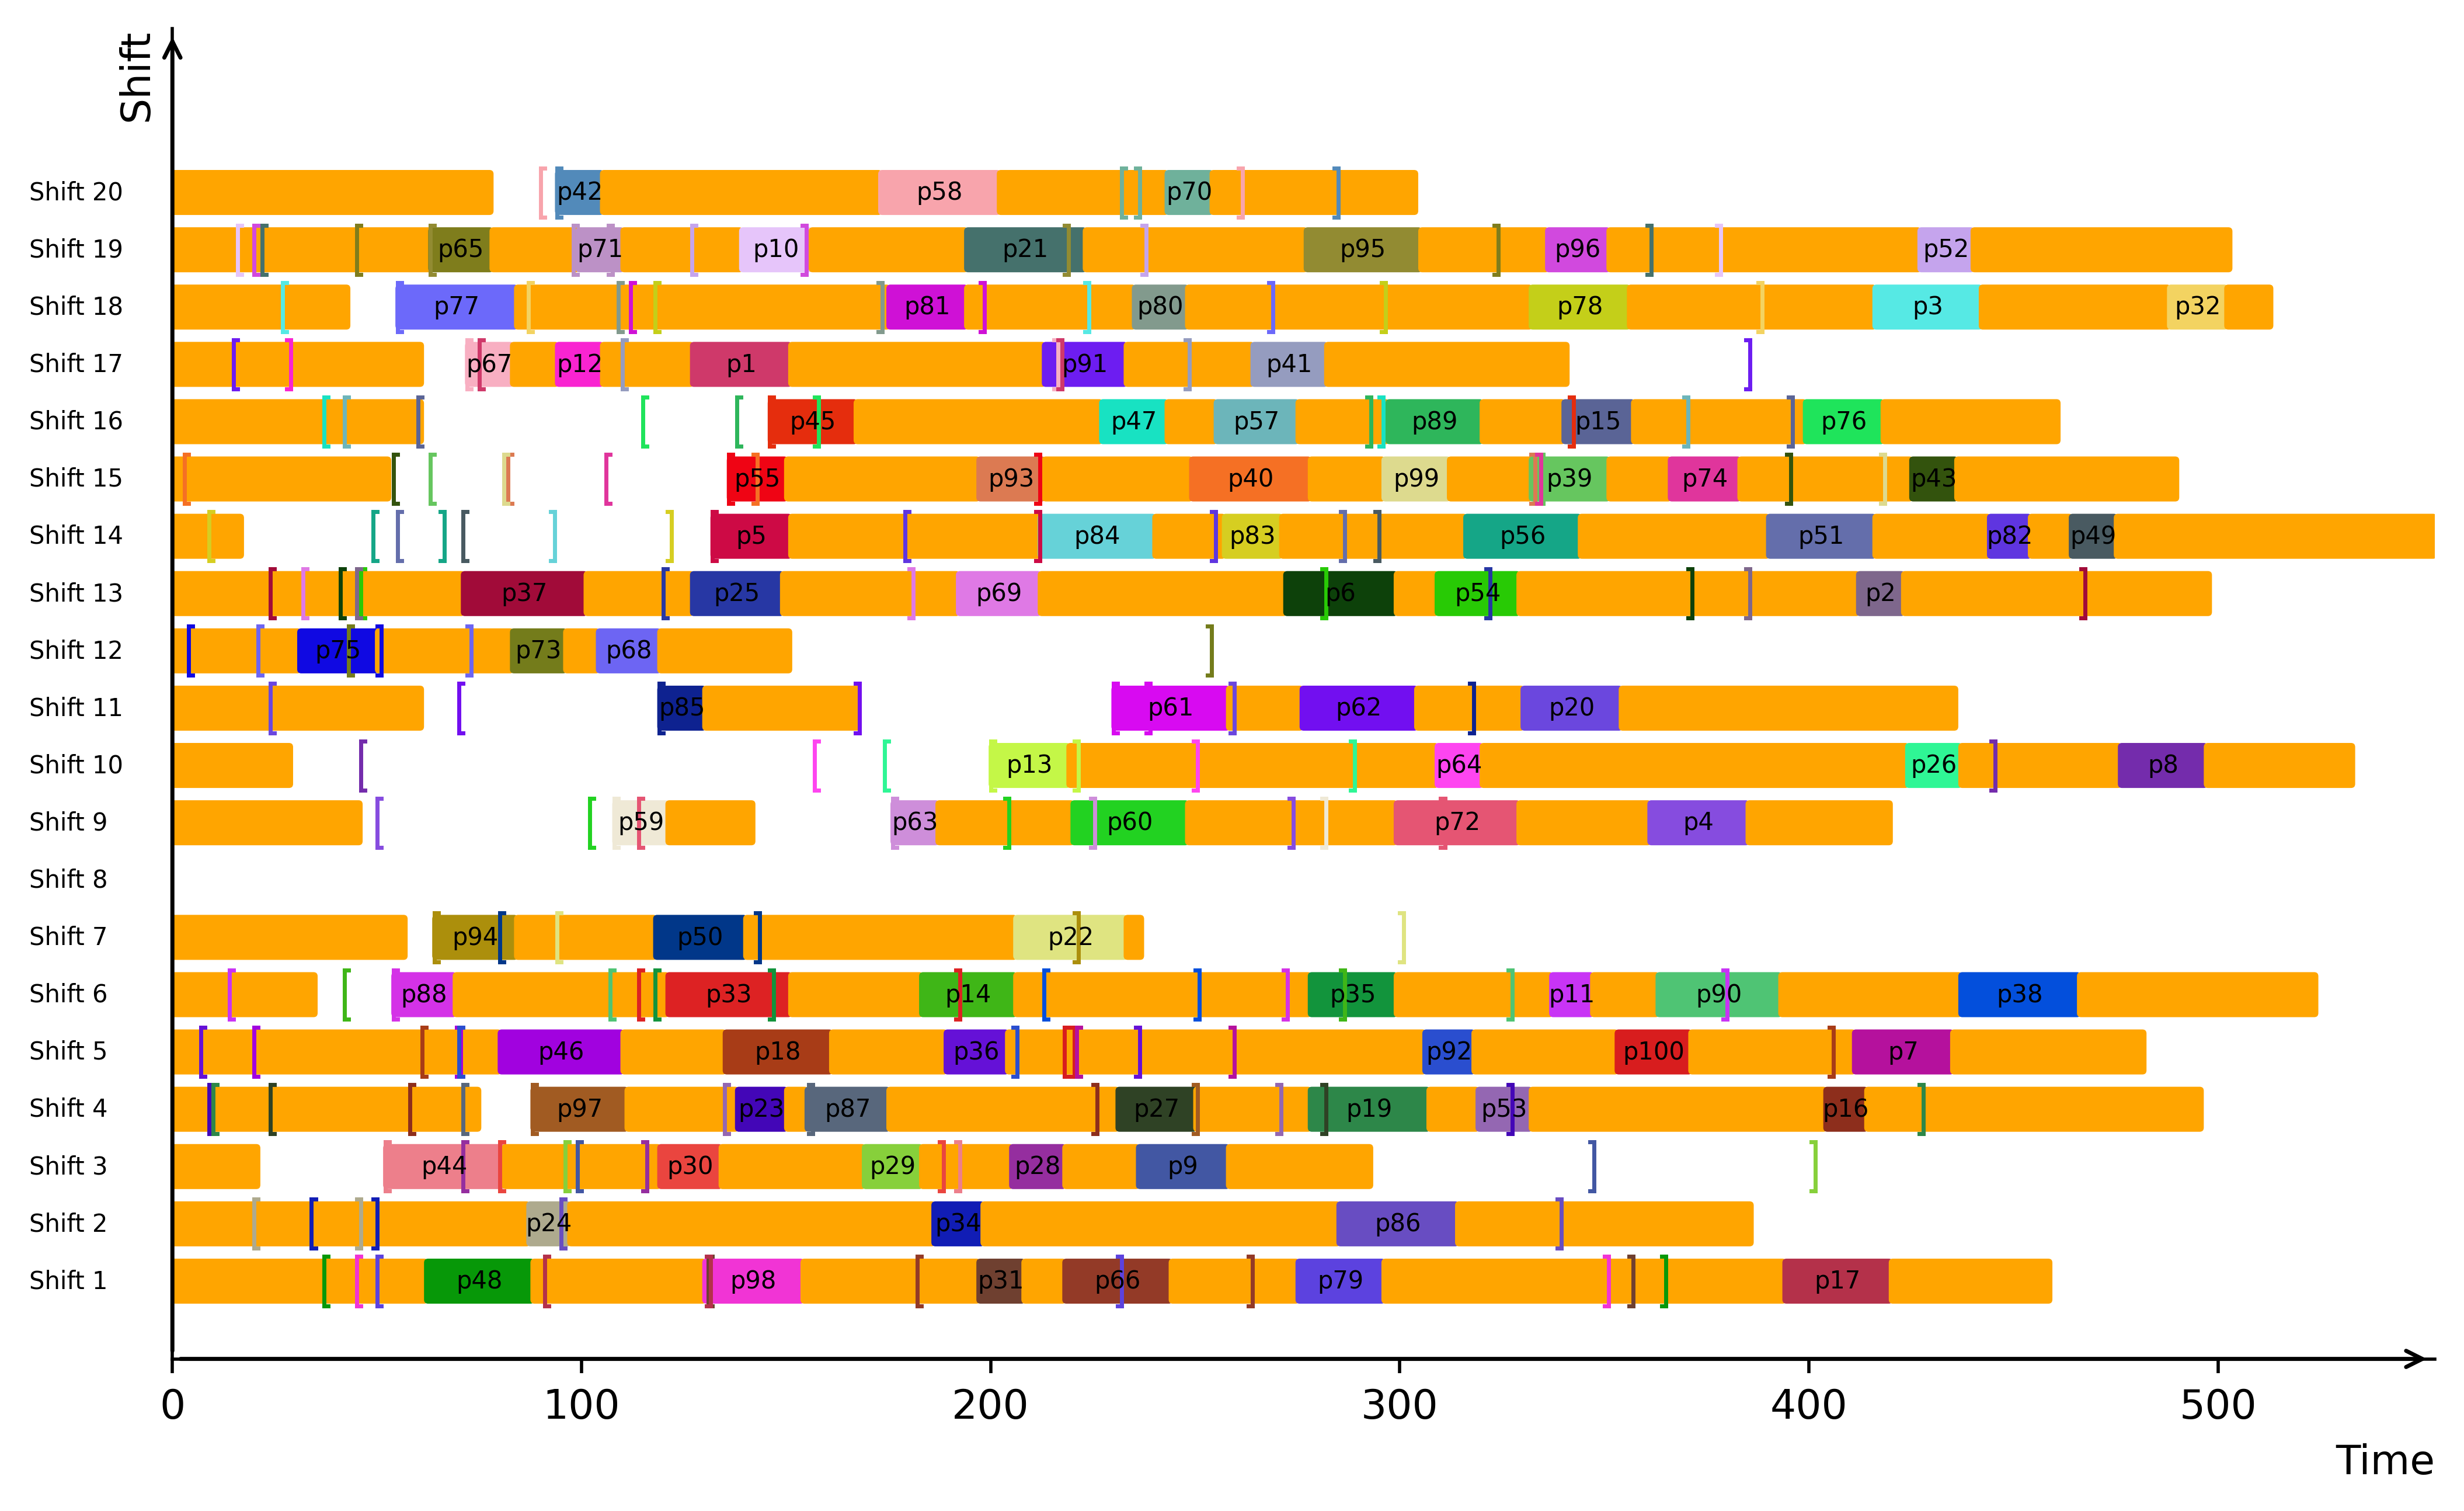

[[], [(48, 62, 0), (98, 130, 0), (31, 197, 0), (66, 218, 0), (79, 275, 43.0), (17, 394, 262.5), 388], [(24, 87, 41.0), (34, 186, 136.0), (86, 285, 0), 281], [(44, 52.0, 0), (30, 119.0, 0), (29, 169.0, 0), (28, 205.0, 89.0), (9, 236.0, 0), 201.0], [(97, 88.0, 0), (23, 138.0, 0), (87, 155.0, 0), (27, 231.0, 0), (19, 278.0, 0), (53, 319.0, 48.0), (16, 404.0, 178.0), 400.0], [(46, 80, 9.5), (18, 135, 0), (36, 189, 0), (92, 306, 99.5), (100, 353, 132.5), (7, 411, 151.5), 364], [(88, 54.0, 0), (33, 121.0, 0), (14, 183.0, 0), (35, 278.0, 131.0), (11, 337.0, 0), (90, 363.0, 35.5), (38, 437.0, 186.0), 460.0], [(94, 64.0, 0), (50, 118.0, 0), (22, 206.0, 0), 122.0], [], [(59, 108.0, 0), (63, 176.0, 0), (60, 220.0, 15.5), (72, 299.0, 0), (4, 361.0, 87.0), 343.0], [(13, 200.0, 0), (64, 309.0, 58.5), (26, 424.0, 135.0), (8, 476.0, 30.5), 464.0], [(85, 119.0, 0), (61, 230.0, 0), (62, 276.0, 108.0), (20, 330.0, 70.5), 318.0], [(75, 31, 0), (73, 83, 0), (68, 104, 31.0), 48], [(37, 71, 0), (25, 127, 0),

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def analysis(individual):
    _solution = [[] for i in range(V+1)]
    unsorted_individual = np.array([[0,0]] + [[individual[i], i+1] for i in range(len(individual))])
    sorted_individual = unsorted_individual[np.argsort(unsorted_individual[:, 0])]
    # Tổng thời gian di chuyển
    time_arrived = 0
    time_start = 0
    # Tổng thời gian tăng ca
    over_time = 0
    # Tổng thời gian chờ
    waiting_time = 0
    for i in range(N):
        if (int(sorted_individual[i, 0])) == 0 and i<N:
            if ((int(sorted_individual[i+1, 0])) == 0):
                continue
        if int(sorted_individual[i, 0]) == 0:
            time_start = max(d[0][int(sorted_individual[1, 1])], s[int(sorted_individual[1, 1])])
            waiting_time += max(0, time_start - e[int(sorted_individual[1, 1])])
            time_arrived += d[0][int(sorted_individual[1, 1])]
            _solution[int(sorted_individual[1, 0])].append((int(sorted_individual[1, 1]), time_start, max(0, time_start - e[int(sorted_individual[1, 1])])))
        else:
            if int(sorted_individual[i, 0]) == int(sorted_individual[i+1, 0]):
                time_start = max(s[int(sorted_individual[i+1, 1])], time_start + p[int(sorted_individual[i, 1])] + d[int(sorted_individual[i, 1])][int(sorted_individual[i+1, 1])])
                waiting_time += max(0, time_start - e[int(sorted_individual[i+1, 1])])
                time_arrived += d[int(sorted_individual[i, 1])][int(sorted_individual[i+1, 1])]
                _solution[int(sorted_individual[i+1, 0])].append((int(sorted_individual[i+1, 1]), time_start, max(0, time_start - e[int(sorted_individual[i+1, 1])])))
            else:      
                time_arrived += d[int(sorted_individual[i, 1])][0]
                over_time += max(0, time_start + p[int(sorted_individual[i, 1])] + d[int(sorted_individual[i, 1])][0] - u[int(sorted_individual[i, 0])])
                _solution[int(sorted_individual[i, 0])].append((max(0, time_start + p[int(sorted_individual[i, 1])] + d[int(sorted_individual[i, 1])][0] - u[int(sorted_individual[i, 0])])))
                time_start = max(d[0][int(sorted_individual[i+1, 1])], s[int(sorted_individual[i+1, 1])])
                waiting_time += max(0, time_start - e[int(sorted_individual[i+1, 1])])
                _solution[int(sorted_individual[i+1, 0])].append((int(sorted_individual[i+1, 1]), time_start, max(0, time_start - e[int(sorted_individual[i+1, 1])])))
        
    time_arrived += d[int(sorted_individual[N, 1])][0]
    over_time += max(0, time_start + p[int(sorted_individual[N, 1])] + d[int(sorted_individual[N, 1])][0] - u[int(sorted_individual[N, 0])])
    _solution[int(sorted_individual[N, 0])].append((max(0, time_start + p[int(sorted_individual[N, 1])] + d[int(sorted_individual[N, 1])][0] - u[int(sorted_individual[N, 0])])))
    return _solution
width = 10
max_time = 0
boxstyle = "round,pad=0.5,rounding_size=1"

h = [i for i in range(0, (N-1)*(width+4) + 1, width+4)]
def random_color():
    return np.random.rand(3,)  # Tạo mảng 3 phần tử, mỗi phần tử trong khoảng [0, 1]

fig, ax = plt.subplots(figsize=(10, 10), dpi=500)
_analysis = analysis(solution)
for i in range(1, len(_analysis)):
    if len(_analysis[i]) > 0:
        for j in range(len(_analysis[i])-1):
            if j == 0:
                r_d = FancyBboxPatch((0, h[i]), d[0][_analysis[i][j][0]], width, linewidth=0, boxstyle=boxstyle, facecolor='orange')
                ax.add_patch(r_d)
                # ax.text(d[0][_analysis[i][j][0]]/2, h[i] + width / 2, f'd0,{_analysis[i][j][0]}', ha='center', va='center', fontsize=6, color='black')
            else:
                r_d = FancyBboxPatch((_analysis[i][j-1][1] + p[_analysis[i][j-1][0]], h[i]), d[_analysis[i][j-1][0]][_analysis[i][j][0]], width, linewidth=0, boxstyle=boxstyle, facecolor='orange')
                ax.add_patch(r_d)
                # ax.text(e_p + d[_analysis[i][j-1][0]][_analysis[i][j][0]]/2, h[i] + width / 2, f'd{_analysis[i][j-1][0]},{_analysis[i][j][0]}', ha='center', va='center', fontsize=6, color='black')
            w_color = random_color()
            r_p = FancyBboxPatch((_analysis[i][j][1], h[i]), p[_analysis[i][j][0]], width, linewidth=0, boxstyle=boxstyle, facecolor=w_color)
            ax.add_patch(r_p)
            ax.text(_analysis[i][j][1] + p[_analysis[i][j][0]]/2, h[i] + width / 2, f'p{_analysis[i][j][0]}', ha='center', va='center', fontsize=6, color='black')
            
            
            l_start = plt.plot([s[_analysis[i][j][0]], s[_analysis[i][j][0]]], [h[i]-1, h[i]+width+1], color=w_color, linestyle='-', linewidth=1)
            plt.plot([s[_analysis[i][j][0]], s[_analysis[i][j][0]]+1], [h[i]-1, h[i]-1], color=w_color, linestyle='-', linewidth=1)
            plt.plot([s[_analysis[i][j][0]], s[_analysis[i][j][0]]+1], [h[i]+width+1, h[i]+width+1], color=w_color, linestyle='-', linewidth=1)
            l_end = plt.plot([e[_analysis[i][j][0]], e[_analysis[i][j][0]]], [h[i]-1, h[i]+width+1], color=w_color, linestyle='-', linewidth=1)
            plt.plot([e[_analysis[i][j][0]], e[_analysis[i][j][0]]-1], [h[i]-1, h[i]-1], color=w_color, linestyle='-', linewidth=1)
            plt.plot([e[_analysis[i][j][0]], e[_analysis[i][j][0]]-1], [h[i]+width+1, h[i]+width+1], color=w_color, linestyle='-', linewidth=1)
            # if j>0 and _analysis[i][j][2]>0:
            #     r_z = FancyBboxPatch((e[_analysis[i][j][0]], h[i]+2), _analysis[i][j][2], width-4, linewidth=0, boxstyle=boxstyle, facecolor=random_color())
            #     ax.add_patch(r_z)
            #     ax.text(e[_analysis[i][j][0]] + _analysis[i][j][2]/2, h[i] + width / 2, f'z{_analysis[i][j][0]}', ha='center', va='center', fontsize=6, color='black')
        
        j = len(_analysis[i])-2
        r_d = FancyBboxPatch((_analysis[i][j][1] + p[_analysis[i][j][0]], h[i]), d[_analysis[i][j][0]][0], width, linewidth=0, boxstyle=boxstyle, facecolor='orange')
        ax.add_patch(r_d)
        # ax.text(e_p + d[_analysis[i][j][0]][0]/2, h[i] + width / 2, f'd{_analysis[i][j][0]},0', ha='center', va='center', fontsize=6, color='black')
        max_time = max(max_time, _analysis[i][j][1] + p[_analysis[i][j][0]] + d[_analysis[i][j][0]][0])
    name_shift = plt.text(-35, h[i]+width/2-3, f"Shift {i}", fontsize=6, color='black', ha='left', va='bottom')

x_lim = max_time
y_lim = len(_analysis) * 15 + 10

# Thêm mũi tên trục x
ax.annotate('', xy=(x_lim, 0), xytext=(0, 0),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

# Thêm mũi tên trục y
ax.annotate('', xy=(0, y_lim), xytext=(0, 0),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

ax.set_xlim(0, x_lim)
ax.set_ylim(0, y_lim)
ax.set_aspect('equal', 'box')
                
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Thêm nhãn và tiêu đề
plt.xlabel("Time", loc='right')
plt.ylabel("Shift", loc='top')

plt.yticks([])

# Hiển thị đồ thị
plt.show()
print(_analysis)

